<a href="https://colab.research.google.com/github/ggrynkiv/Question-1/blob/master/regime_nowcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
#from matplotlib.pylab import*
import time
import math
import scipy.stats
import importlib as impl
import functools
import pickle
import urllib
import sklearn
import matplotlib.pyplot as plt
from scipy.optimize import minimize, show_options
from scipy.stats import gennorm
from __future__ import division
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, \
cross_val_score, cross_val_predict, train_test_split
from sklearn.ensemble import AdaBoostRegressor
from google.colab import auth
from google.cloud import storage
import pandas_gbq
import requests

!pip install gcsfs
import gcsfs

### This files aims to label starategies as Winner, Loser or Neutral for different volatility regimes


## Upload Data

In [15]:
auth.authenticate_user()

project_id = "ConfindenceAI"
bucket_name = "unstructured_info"


tclient = storage.Client(project=project_id)
bucket = tclient.get_bucket(bucket_name)

blobs = bucket.list_blobs()
blobs

raw_data = {}

for file in blobs:
    filename = file.name
    
    try:
      temp = pd.read_csv('gs://'+bucket_name+'/'+filename)
      x = filename.split(".")
      raw_data[x[0]] = temp
    except: 
      temp = pd.read_excel('gs://'+bucket_name+'/'+filename,  header= 0)
      x = filename.split(".")
      raw_data[x[0]] = temp


upload vix

In [37]:
project_id = "ConfindenceAI"
bucket_name = "strategy_data"

vix= pd.DataFrame()

tclient = storage.Client(project=project_id)
bucket = tclient.get_bucket(bucket_name)
vix = pd.read_csv('gs://'+bucket_name+'/'+'VIX.csv')

In [38]:
vix['Date'] = pd.to_datetime(vix['Date'])

In [39]:
raw_data.keys()

dict_keys(['Equity_Uncertainty_Index', 'Quandle_Investment_Sentiment', 'Twitter_Uncertainty'])

In [40]:
data = raw_data['Equity_Uncertainty_Index']
data.rename(columns = {'Value': 'EUI'}, inplace = True)
data['Date'] = pd.to_datetime(data['Date'])
data  = pd.merge(data, raw_data['Twitter_Uncertainty'], left_on = 'Date', right_on = 'date')
data.drop(columns=['date'], inplace = True)
data.dropna(subset = ['Date'], inplace = True)

In [41]:
data

,Date,EUI,TEU,TMU
0,2020-07-19,286.29,245.612501,280.777668
1,2020-07-18,87.63,312.903597,255.494370
2,2020-07-17,138.37,531.599659,585.507932
3,2020-07-16,141.32,706.556509,585.507932
4,2020-07-15,175.09,689.733735,601.476330
...,...,...,...,...
3483,2011-01-05,6.18,30.280993,46.574495
3484,2011-01-04,33.85,47.103767,62.542893
3485,2011-01-03,21.97,50.468322,42.582395
3486,2011-01-02,85.31,35.327825,17.299098


In [42]:
data.dropna()
data

,Date,EUI,TEU,TMU
0,2020-07-19,286.29,245.612501,280.777668
1,2020-07-18,87.63,312.903597,255.494370
2,2020-07-17,138.37,531.599659,585.507932
3,2020-07-16,141.32,706.556509,585.507932
4,2020-07-15,175.09,689.733735,601.476330
...,...,...,...,...
3483,2011-01-05,6.18,30.280993,46.574495
3484,2011-01-04,33.85,47.103767,62.542893
3485,2011-01-03,21.97,50.468322,42.582395
3486,2011-01-02,85.31,35.327825,17.299098


In [43]:
data  = pd.merge(data, vix[['Date', 'Adj Close']], on = 'Date', how = 'outer')

In [44]:
data.rename(columns = {'Adj Close': 'VIX'}, inplace = True)

In [45]:
data

,Date,EUI,TEU,TMU,VIX
0,2020-07-19,286.29,245.612501,280.777668,NaN
1,2020-07-18,87.63,312.903597,255.494370,NaN
2,2020-07-17,138.37,531.599659,585.507932,25.680000
3,2020-07-16,141.32,706.556509,585.507932,28.000000
4,2020-07-15,175.09,689.733735,601.476330,27.760000
...,...,...,...,...,...
8641,2010-12-30,NaN,NaN,NaN,17.520000
8642,2010-12-31,NaN,NaN,NaN,17.750000
8643,2020-07-20,NaN,NaN,NaN,24.459999
8644,2020-07-21,NaN,NaN,NaN,24.840000


In [46]:
data.sort_values(by=['Date'])

,Date,EUI,TEU,TMU,VIX
3488,1990-07-23,NaN,NaN,NaN,23.680000
3489,1990-07-24,NaN,NaN,NaN,21.790001
3490,1990-07-25,NaN,NaN,NaN,20.190001
3491,1990-07-26,NaN,NaN,NaN,20.260000
3492,1990-07-27,NaN,NaN,NaN,21.120001
...,...,...,...,...,...
1,2020-07-18,87.63,312.903597,255.494370,NaN
0,2020-07-19,286.29,245.612501,280.777668,NaN
8643,2020-07-20,NaN,NaN,NaN,24.459999
8644,2020-07-21,NaN,NaN,NaN,24.840000


In [49]:
df = data.loc[pd.notnull(data['TMU'])]

In [50]:
df

,Date,EUI,TEU,TMU,VIX
0,2020-07-19,286.29,245.612501,280.777668,NaN
1,2020-07-18,87.63,312.903597,255.494370,NaN
2,2020-07-17,138.37,531.599659,585.507932,25.680000
3,2020-07-16,141.32,706.556509,585.507932,28.000000
4,2020-07-15,175.09,689.733735,601.476330,27.760000
...,...,...,...,...,...
3483,2011-01-05,6.18,30.280993,46.574495,17.020000
3484,2011-01-04,33.85,47.103767,62.542893,17.379999
3485,2011-01-03,21.97,50.468322,42.582395,17.610001
3486,2011-01-02,85.31,35.327825,17.299098,NaN


In [155]:
df['TMU_lag'] = df['TMU'].shift(periods=1) 
df['TEU_lag'] = df['TEU'].shift(periods=1) 
df['EUI_lag'] = df['EUI'].shift(periods=1) 
df['TMU_2lag'] = df['TMU'].shift(periods=2) 
df['TEU_2lag'] = df['TEU'].shift(periods=2) 
df['EUI_2lag'] = df['EUI'].shift(periods=2) 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [156]:
model_data = df[['Date','VIX',	'TMU_lag',	'TEU_lag',	'EUI_lag', 'TMU_2lag',	'TEU_2lag',	'EUI_2lag']]

In [207]:
df

,Date,EUI,TEU,TMU,VIX,TMU_lag,TEU_lag,EUI_lag,TMU_2lag,TEU_2lag,EUI_2lag
0,2020-07-19,286.29,245.612501,280.777668,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-07-18,87.63,312.903597,255.494370,NaN,280.777668,245.612501,286.29,NaN,NaN,NaN
2,2020-07-17,138.37,531.599659,585.507932,25.680000,255.494370,312.903597,87.63,280.777668,245.612501,286.29
3,2020-07-16,141.32,706.556509,585.507932,28.000000,585.507932,531.599659,138.37,255.494370,312.903597,87.63
4,2020-07-15,175.09,689.733735,601.476330,27.760000,585.507932,706.556509,141.32,585.507932,531.599659,138.37
...,...,...,...,...,...,...,...,...,...,...,...
3483,2011-01-05,6.18,30.280993,46.574495,17.020000,54.558694,52.150599,5.41,54.558694,55.515154,6.64
3484,2011-01-04,33.85,47.103767,62.542893,17.379999,46.574495,30.280993,6.18,54.558694,52.150599,5.41
3485,2011-01-03,21.97,50.468322,42.582395,17.610001,62.542893,47.103767,33.85,46.574495,30.280993,6.18
3486,2011-01-02,85.31,35.327825,17.299098,NaN,42.582395,50.468322,21.97,62.542893,47.103767,33.85


In [166]:
model_data.dropna(inplace = True)
model_data['VIX_lag']= model_data[['VIX']].shift(periods=1) 
model_data.dropna(inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Thi

In [167]:
joint = model_data
joint.sort_values(by=['Date'], ascending=True, inplace = True, ignore_index = True)
joint.dropna(inplace = True)
joint

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,VIX,TMU_lag,TEU_lag,EUI_lag,TMU_2lag,TEU_2lag,EUI_2lag,VIX_lag
0,2011-01-04,17.379999,46.574495,30.280993,6.18,54.558694,52.150599,5.41,17.610001
1,2011-01-05,17.020000,54.558694,52.150599,5.41,54.558694,55.515154,6.64,17.379999
2,2011-01-06,17.400000,54.558694,55.515154,6.64,31.936796,25.234161,39.36,17.020000
3,2011-01-07,17.139999,31.936796,25.234161,39.36,30.606096,23.551884,42.02,17.400000
4,2011-01-10,17.540001,59.881493,95.889812,7.89,35.928896,37.010103,37.62,17.139999
...,...,...,...,...,...,...,...,...,...
2395,2020-07-13,32.189999,646.720125,615.713530,71.09,601.476330,689.733735,175.09,27.290001
2396,2020-07-14,29.520000,601.476330,689.733735,175.09,585.507932,706.556509,141.32,32.189999
2397,2020-07-15,27.760000,585.507932,706.556509,141.32,585.507932,531.599659,138.37,29.520000
2398,2020-07-16,28.000000,585.507932,531.599659,138.37,255.494370,312.903597,87.63,27.760000


Split data into train-test

In [168]:
lenght = joint.shape[0]
share = 0.97
train = joint.loc[0:int(lenght*share)]
test = joint.loc[int(lenght*share)+1:]


In [220]:
from sklearn.linear_model import LinearRegression
# Create linear regression object
regr = linear_model.LinearRegression()
features = ['VIX_lag', 'EUI_lag', 'TMU_2lag'] 
#features = ['TMU_2lag', 'TEU_lag', 'TMU_lag'] 
x = train[features]
y = train[['VIX']]
# Train the model using the training sets
regr.fit(x, y)
regr.score(x, y)
regr.coef_
regr.score(test[features], test[['VIX']])
#test['vix_predict'] = regr.predict(test[features])

0.7514265896562975

In [214]:
test

,Date,VIX,TMU_lag,TEU_lag,EUI_lag,TMU_2lag,TEU_2lag,EUI_2lag,VIX_lag,vix_predict
2329,2020-04-07,46.700001,1099.158073,868.055140,285.79,1068.551976,1011.048719,203.41,45.240002,44.745281
2330,2020-04-08,43.349998,1068.551976,1011.048719,203.41,777.128710,669.546406,330.69,46.700001,45.402287
2331,2020-04-09,41.669998,777.128710,669.546406,330.69,436.469550,471.037673,376.38,43.349998,43.096230
2332,2020-04-13,41.169998,1021.977482,931.981681,178.24,1048.591479,1016.095552,179.98,41.669998,40.711452
2333,2020-04-14,37.759998,1048.591479,1016.095552,179.98,1088.512474,1017.777829,173.10,41.169998,40.265007
...,...,...,...,...,...,...,...,...,...,...
2395,2020-07-13,32.189999,646.720125,615.713530,71.09,601.476330,689.733735,175.09,27.290001,26.584738
2396,2020-07-14,29.520000,601.476330,689.733735,175.09,585.507932,706.556509,141.32,32.189999,31.897920
2397,2020-07-15,27.760000,585.507932,706.556509,141.32,585.507932,531.599659,138.37,29.520000,29.182694
2398,2020-07-16,28.000000,585.507932,531.599659,138.37,255.494370,312.903597,87.63,27.760000,27.579046


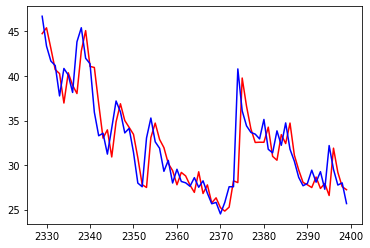

In [221]:
plt.plot(test['vix_predict'], color = 'r')
plt.plot(test['VIX'],  color = 'b')

In [219]:
import statsmodels.api as sm
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 1.580e+04
Date:                Thu, 23 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:42:34   Log-Likelihood:                -4693.0
No. Observations:                2329   AIC:                             9392.
Df Residuals:                    2326   BIC:                             9409.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5265      0.098      5.352      0.0

In [68]:
 model_data[['VIX']].shift

array([         nan, 280.77766754, 255.49437047, ...,  62.54289277,
        42.58239508,  17.299098  ])

In [83]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(model_data[['TMU_lag']], model_data[['VIX']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [81]:
model_data[['TMU_lag']]

,TMU_lag
2,255.494370
3,585.507932
4,585.507932
5,601.476330
6,646.720125
...,...
3481,31.936796
3482,54.558694
3483,54.558694
3484,46.574495


In [91]:
model_data['VIX_lag']= model_data[['VIX']].shift(periods=1) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Examine Distribution in Different regimes

In [ ]:
len(strategy_list)

8

Plot distribution in diffrent regimes

```
`# This is formatted as code`
```



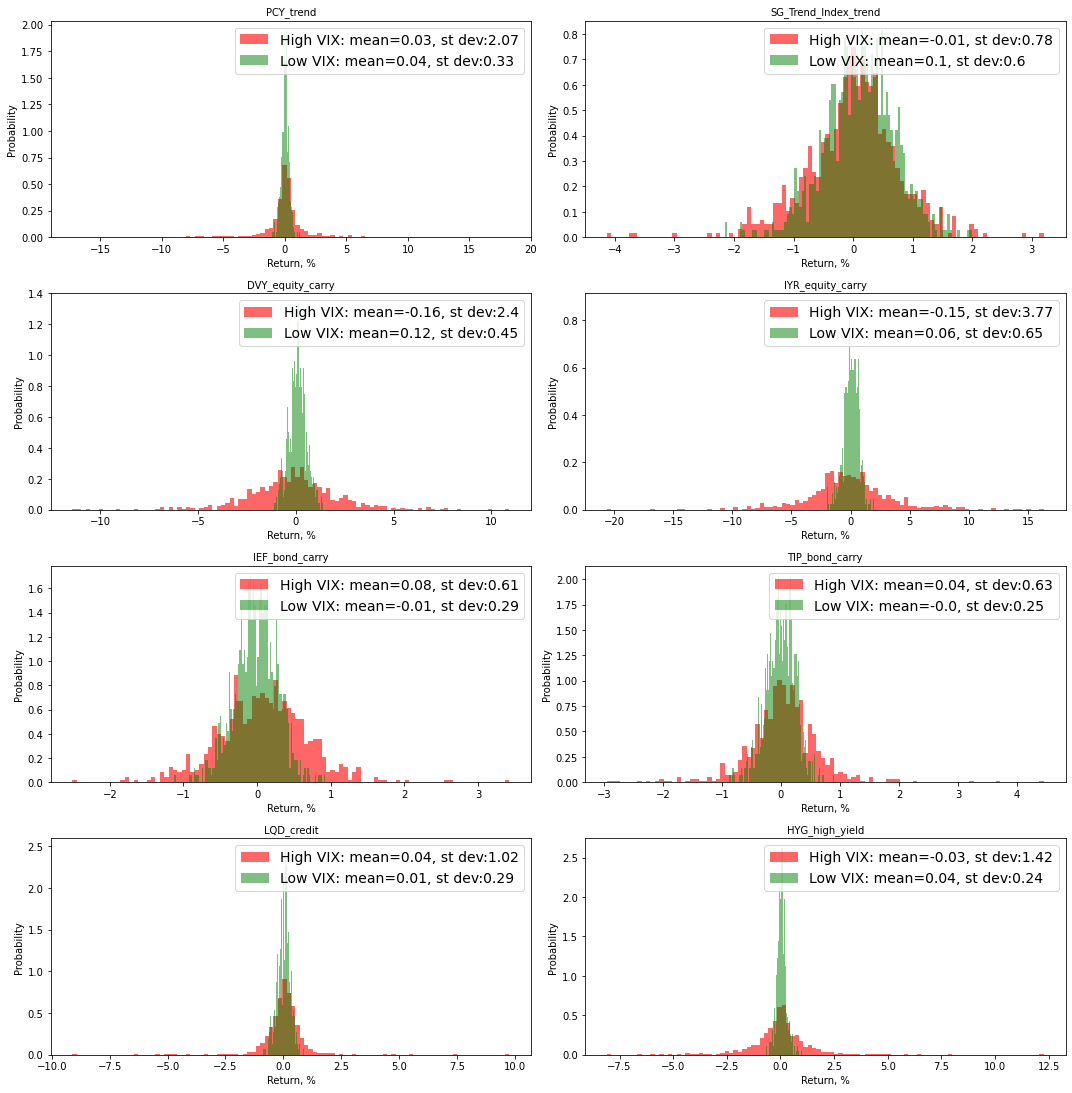

In [ ]:
len1= 2
len2 = len(strategy_list)


# plot distribution of the portfolio conditional on view
%matplotlib inline
fig = plt.figure(figsize=(15,30))

i = 1

for item in strategy_list:
  plt.subplot(len2, len1, i)
  _ = plt.hist(df[item].loc[df['VIX']>high_vix], density = True, bins = 100, facecolor='red', alpha=0.6)
  _ = plt.hist(df[item].loc[df['VIX']<low_vix], density = True , bins = 100, facecolor ='g', alpha=0.5)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.xlabel('Return, %',fontsize = 10)
  plt.ylabel('Probability',fontsize = 10)
  plt.title(item,fontsize = 10)
  plt.legend(['High VIX: mean='+str(np.round(df[item].loc[df['VIX']>high_vix].mean(),2))+', '+\
            'st dev:'+str(np.round(df[item].loc[df['VIX']>high_vix].std(),2)),
           'Low VIX: mean='+str(np.round(df[item].loc[df['VIX']<low_vix].mean(),2))+', '+\
            'st dev:'+str(np.round(df[item].loc[df['VIX']<low_vix].std(),2))], fontsize = 14)
  i+=1
fig.tight_layout()
fig.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


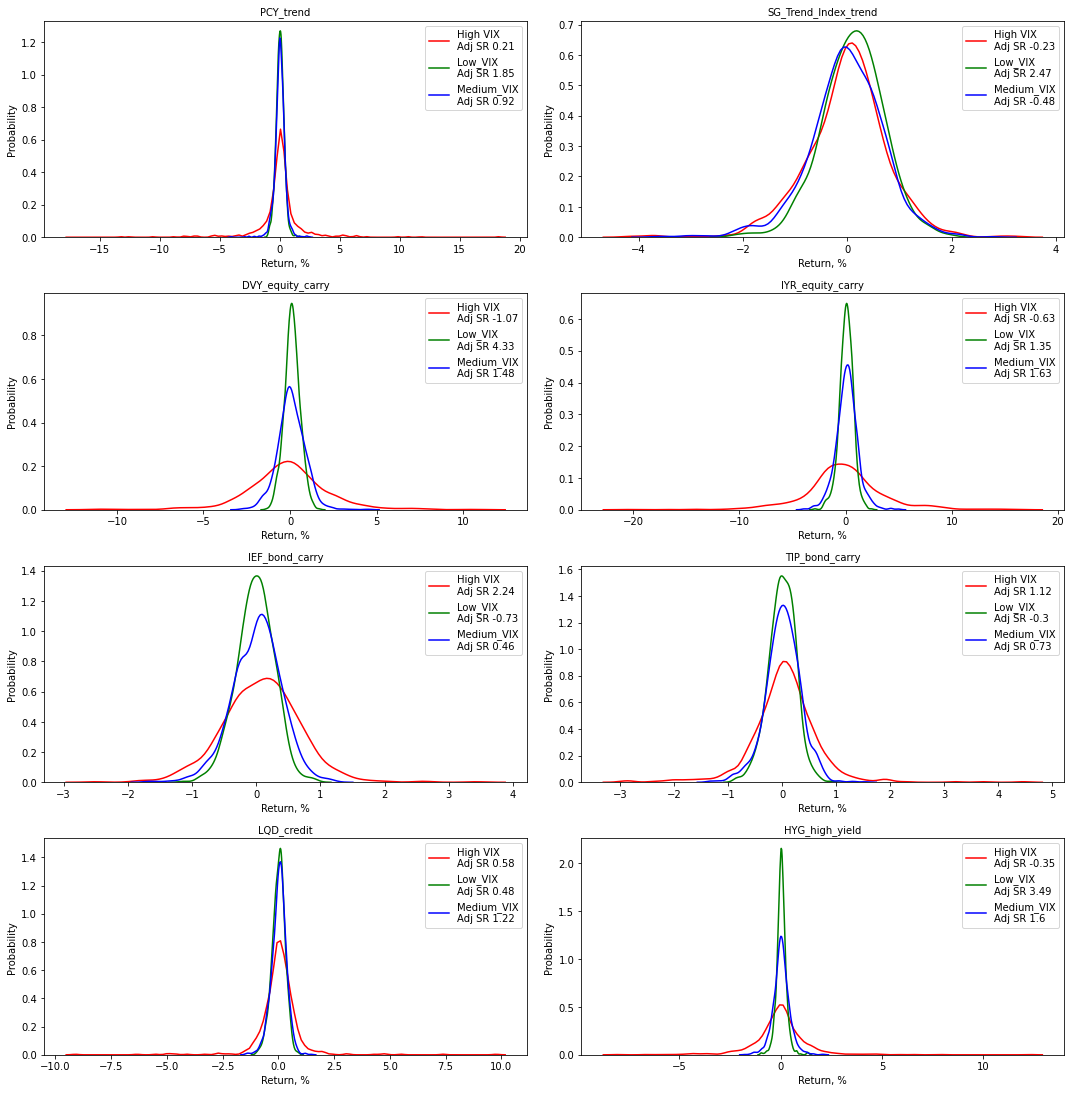

In [ ]:
len1= 2
len2 = len(strategy_list)
import seaborn as sns

# plot distribution of the portfolio conditional on view
%matplotlib inline
fig = plt.figure(figsize=(15,30))
#fig, axes =plt.subplots(len2,len1)
#fig, ax = plt.subplots(figsize=(10,8))
i = 1

for item in strategy_list:
  plt.subplot(len2, len1, i)
  #fig, ax = plt.subplots(figsize=(10,8))
  #_ = plt.hist(df[item].loc[df['VIX']>high_vix], density = True, bins = 20, facecolor='red', alpha=0.6)
  #_ = plt.hist(df[item].loc[df['VIX']<low_vix], density = True , bins = 20, facecolor ='g', alpha=0.5)

  #sns.boxplot(  y=t, x= "a", data=df,  orient='v',ax=axes[i % 2] ,  palette= flatui)
  sns.distplot(df[item].loc[df['VIX']>high_vix], hist=False, rug=False, color='red', label='High VIX');
  sns.distplot(df[item].loc[df['VIX']<low_vix], hist=False, rug=False, color ='g',label = 'Low VIX' );
  sns.distplot(df[item].loc[(df['VIX']>low_vix)& (df['VIX']<high_vix) ], hist=False, rug=False, color ='b',label = 'medium VIX' );

  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.xlabel('Return, %',fontsize = 10)
  plt.ylabel('Probability',fontsize = 10)
  plt.title(item,fontsize = 10)
  #plt.legend(['High VIX: mean='+str(np.round(df[item].loc[df['VIX']>high_vix].mean(),2))+', '+\
       #     'st dev:'+str(np.round(df[item].loc[df['VIX']>high_vix].std(),2)),
        #   'Low VIX: mean='+str(np.round(df[item].loc[df['VIX']<low_vix].mean(),2))+', '+\
  plt.legend(['High VIX'+'\n'+'Adj SR '+str(stats['stats_highVIX'][item]['Adj Sharpe']),\
              'Low_VIX'+'\n'+'Adj SR '+str(stats['stats_lowVIX'][item]['Adj Sharpe']),\
              'Medium_VIX'+'\n'+'Adj SR '+str(stats['stats_mediumVIX'][item]['Adj Sharpe'])])
  i+=1
fig.tight_layout()
fig.show()

In [ ]:
import seaborn as sns

### High VIX:

- Bond Carry is a winner
- outweight Bond Carry by 50% \\
- LQD_credit is neutral \\
- Trend, Equity carry are lossers

### Medium VIX

 - LQD_credit, HYG_high_yield and Equity carry are the winners
  outweight them by 50%
 - Bond carry and Trend are neutral

### Low VIX

- Trend, Equity carry, HYG_high_yield are the winners

- outweights them by 50%

- LQD_credit is neutral

- Bond Carry is a loser



## Tactical Allocation

High Vix

In [ ]:
stats['returns']
strategy_list
weight = 1/len(strategy_list)
stats['returns']['equal_weight'] =0.00
stats['returns']['tactical_all'] =0.00
stats['stats_highVIX']['equal_weight'] = 0.00
stats['stats_lowVIX']['equal_weight'] = 0.00
stats['stats_mediumVIX']['equal_weight'] = 0.00

stats['stats_highVIX']['tactical_all'] = 0.00
stats['stats_lowVIX']['tactical_all'] = 0.00
stats['stats_mediumVIX']['tactical_all'] = 0.00


for item in strategy_list: 
  stats['returns']['equal_weight'] = weight* stats['returns'][item]+stats['returns']['equal_weight']

outweight = 0.6

stats['returns']['tactical_all'].loc[stats['returns']['VIX'] >= high_vix] = \
outweight*(0.5* stats['returns']['IEF_bond_carry'].loc[stats['returns']['VIX'] >= high_vix]+\
           0.5* stats['returns']['TIP_bond_carry'].loc[stats['returns']['VIX'] >= high_vix])+\
           weight*stats['returns']['LQD_credit'].loc[stats['returns']['VIX'] >= high_vix]+ \
          (1- outweight - weight)* (0.2*stats['returns']['LQD_credit'].loc[stats['returns']['VIX'] >= high_vix] +
            0.2*stats['returns']['SG_Trend_Index_trend'].loc[stats['returns']['VIX'] >= high_vix] +\
            0.2*stats['returns']['DVY_equity_carry'].loc[stats['returns']['VIX'] >= high_vix] +\
            0.2*stats['returns']['IYR_equity_carry'].loc[stats['returns']['VIX'] >= high_vix] +
            0.2*stats['returns']['HYG_high_yield'].loc[stats['returns']['VIX'] >= high_vix])
          


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Medium VIX

In [ ]:
stats['returns']['tactical_all'].loc[(stats['returns']['VIX'] <= high_vix) & (stats['returns']['VIX'] > low_vix)] = \
outweight*(0.25* stats['returns']['DVY_equity_carry'].loc[(stats['returns']['VIX'] <= high_vix) & \
                                    (stats['returns']['VIX'] > low_vix)]  +
           0.25* stats['returns']['IYR_equity_carry'].loc[(stats['returns']['VIX'] <= high_vix) &\
                                                         (stats['returns']['VIX'] > low_vix)]  +
           0.25* stats['returns']['HYG_high_yield'].loc[(stats['returns']['VIX'] <= high_vix) &\
                                                        (stats['returns']['VIX'] > low_vix)]  +\
           0.25*stats['returns']['LQD_credit'].loc[(stats['returns']['VIX'] <= high_vix) & \
                                                   (stats['returns']['VIX'] > low_vix)])+ \
          (1- outweight)* (0.25*stats['returns']['SG_Trend_Index_trend'].loc[(stats['returns']['VIX'] <= high_vix) & \
                                                                             (stats['returns']['VIX'] > low_vix)]+\
            0.25*stats['returns']['PCY_trend'].loc[(stats['returns']['VIX'] <= high_vix) & \
                                                   (stats['returns']['VIX'] > low_vix)]+\
            0.25*stats['returns']['IEF_bond_carry'].loc[(stats['returns']['VIX'] <= high_vix) & \
                                                        (stats['returns']['VIX'] > low_vix)]+
            0.25*stats['returns']['TIP_bond_carry'].loc[(stats['returns']['VIX'] <= high_vix) & \
                                                        (stats['returns']['VIX'] > low_vix)])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Low VIX

In [ ]:
stats['returns']['tactical_all'].loc[stats['returns']['VIX'] < low_vix] = \
outweight*(0.2* stats['returns']['IYR_equity_carry'].loc[stats['returns']['VIX'] < low_vix]+\
           0.2* stats['returns']['DVY_equity_carry'].loc[stats['returns']['VIX'] < low_vix]+
           0.2* stats['returns']['PCY_trend'].loc[stats['returns']['VIX']< low_vix]+
          0.2* stats['returns']['SG_Trend_Index_trend'].loc[stats['returns']['VIX']< low_vix]+\
          0.2*stats['returns']['HYG_high_yield'].loc[stats['returns']['VIX'] < low_vix]) +\

             weight*stats['returns']['LQD_credit'].loc[stats['returns']['VIX'] < low_vix]+ \
          (1- outweight - weight)* (0.5*stats['returns']['TIP_bond_carry'].loc[stats['returns']['VIX'] < low_vix] +
            0.5*stats['returns']['TIP_bond_carry'].loc[stats['returns']['VIX'] < low_vix])
          

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
stats['stats']

,PCY_trend,SG_Trend_Index_trend,DVY_equity_carry,IYR_equity_carry,IEF_bond_carry,TIP_bond_carry,LQD_credit,HYG_high_yield
Mean Return,0.03,0.01,0.03,0.04,0.02,0.02,0.03,0.02
Vol,1.09,0.71,1.35,2.05,0.43,0.41,0.58,0.78
Sharpe,0.42,0.28,0.32,0.29,0.82,0.66,0.69,0.45
Skewness,-0.72,-0.49,-0.43,-0.14,0.15,0.25,0.04,0.79
MaxDD,-17.26,-4.14,-11.43,-20.61,-2.51,-2.95,-9.11,-8.1
Adj Sharpe,0.4,0.27,0.31,0.29,0.84,0.68,0.69,0.48


In [ ]:
dev_strategies = ['equal_weight', 'tactical_all'] 



for strategy in dev_strategies:
  stats['stats'][strategy] =0
  stats['stats'][strategy]['Sharpe'] = round(stats['returns'][strategy].mean()/stats['returns'][strategy].std()*(252**0.5),2)
  sharpe = stats['stats'][strategy]['Sharpe']
  stats['stats'][strategy]['Vol'] = round(stats['returns'][strategy].std(),2)
  stats['stats'][strategy]['MaxDD'] = round(stats['returns'][strategy].min(),2)
  stats['stats'][strategy]['Skewness'] = round(stats['returns'][strategy].skew(),2)
  skew = stats['stats'][strategy]['Skewness']
  kur = round(stats['returns'][strategy].kurtosis(),2)
  stats['stats'][strategy]['Mean Return'] = round(stats['returns'][strategy].mean(),2)
  stats['stats'][strategy]['Adj Sharpe'] = round(sharpe*(1 + skew/6*sharpe),2)


#stats['stats_highVIX'] = pd.DataFrame(columns = strategy_list, index = ['Mean Return', 'Vol', 'Sharpe', 'Skewness', \
                                                                       # 'MaxDD', 'Adj Sharpe'])
for strategy in dev_strategies:
  stats['stats_highVIX'][strategy]['Sharpe'] = round(stats['returns'][strategy].loc[stats['returns']['VIX']>high_vix]
                        .mean()/stats['returns'][strategy].loc[stats['returns']['VIX']>high_vix].std()*(252**0.5),2)
  sharpe =  stats['stats_highVIX'][strategy]['Sharpe']
  stats['stats_highVIX'][strategy]['Vol'] = round(stats['returns'][strategy].loc[stats['returns']['VIX']>high_vix].std(),2)
  stats['stats_highVIX'][strategy]['MaxDD'] = round(stats['returns'][strategy].loc[stats['returns']['VIX']>high_vix].min(),2)
  stats['stats_highVIX'][strategy]['Skewness'] = round(stats['returns'][strategy].loc[stats['returns']['VIX']>high_vix].skew(),2)
  stats['stats_highVIX'][strategy]['Mean Return'] = round(stats['returns'][strategy].loc[stats['returns']['VIX']>high_vix].mean(),2)
  skew = stats['stats_highVIX'][strategy]['Skewness']
  kur = round(stats['returns'][strategy].loc[stats['returns']['VIX']>high_vix].kurtosis(),2)
  stats['stats_highVIX'][strategy]['Adj Sharpe'] = round(sharpe *(1 + skew/6*sharpe),2)

#stats['stats_lowVIX'] = pd.DataFrame(columns = strategy_list, index = ['Mean Return', 'Vol', 'Sharpe', 'Skewness', 'MaxDD',\
                                                                        #'Adj Sharpe'])

for strategy in dev_strategies:
  stats['stats_lowVIX'][strategy]['Sharpe'] = round(stats['returns'][strategy].loc[stats['returns']['VIX']<low_vix]
                                             .mean()/stats['returns'][strategy].loc[stats['returns']['VIX']<low_vix].std()\
                                             *(252**0.5),2)
  sharpe = stats['stats_lowVIX'][strategy]['Sharpe']
  stats['stats_lowVIX'][strategy]['Vol'] = round(stats['returns'][strategy].loc[stats['returns']['VIX']<low_vix].std(),2)
  stats['stats_lowVIX'][strategy]['MaxDD'] = round(stats['returns'][strategy].loc[stats['returns']['VIX']<low_vix].min(),2)
  stats['stats_lowVIX'][strategy]['Skewness'] = round(stats['returns'][strategy].loc[stats['returns']['VIX']<low_vix].skew(),2)
  stats['stats_lowVIX'][strategy]['Mean Return'] = round(stats['returns'][strategy].loc[stats['returns']['VIX']<low_vix].mean(),2)
  skew = stats['stats_lowVIX'][strategy]['Skewness']
  kur = round(stats['returns'][strategy].loc[stats['returns']['VIX']<low_vix].kurtosis(),2)
  stats['stats_lowVIX'][strategy]['Adj Sharpe'] = round(sharpe *(1 + skew/6*sharpe),2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/pyt

In [ ]:
stats['stats_highVIX']

,PCY_trend,SG_Trend_Index_trend,DVY_equity_carry,IYR_equity_carry,IEF_bond_carry,TIP_bond_carry,LQD_credit,HYG_high_yield,equal_weight,tactical_all
Mean Return,0.03,-0.01,-0.16,-0.15,0.08,0.04,0.04,-0.03,-0.02,0.02
Vol,2.07,0.78,2.4,3.77,0.61,0.63,1.02,1.42,0.97,0.53
Sharpe,0.21,-0.23,-1.05,-0.63,2.1,1.07,0.58,-0.36,-0.34,0.73
Skewness,-0.41,-0.48,-0.11,0.05,0.19,0.26,0.03,0.63,-0.24,0.00
MaxDD,-17.26,-4.14,-11.43,-20.61,-2.51,-2.95,-9.11,-8.1,-5.05,-2.80
Adj Sharpe,0.21,-0.23,-1.07,-0.63,2.24,1.12,0.58,-0.35,-0.34,0.73


In [ ]:
dev_strategies = ['equal_weight', 'tactical_all'] 


for strategy in dev_strategies:
  stats['stats'][strategy] =0.00 
  stats['stats'][strategy]['Sharpe'] = round(stats['returns'][strategy].mean()/stats['returns'][strategy].std()*(252**0.5),2)
  sharpe = stats['stats'][strategy]['Sharpe']
  stats['stats'][strategy]['Vol'] = round(stats['returns'][strategy].std(),2)
  stats['stats'][strategy]['MaxDD'] = round(stats['returns'][strategy].min(),2)
  stats['stats'][strategy]['Skewness'] = round(stats['returns'][strategy].skew(),2)
  skew = stats['stats'][strategy]['Skewness']
  kur = round(stats['returns'][strategy].kurtosis(),2)
  stats['stats'][strategy]['Mean Return'] = round(stats['returns'][strategy].mean(),2)
  stats['stats'][strategy]['Adj Sharpe'] = round(sharpe*(1 + skew/6*sharpe),2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopy

In [ ]:
stats['stats']

,PCY_trend,SG_Trend_Index_trend,DVY_equity_carry,IYR_equity_carry,IEF_bond_carry,TIP_bond_carry,LQD_credit,HYG_high_yield,equal_weight,tactical_all
Mean Return,0.03,0.01,0.03,0.04,0.02,0.02,0.03,0.02,0.02,0.04
Vol,1.09,0.71,1.35,2.05,0.43,0.41,0.58,0.78,0.55,0.38
Sharpe,0.42,0.28,0.32,0.29,0.82,0.66,0.69,0.45,0.69,1.56
Skewness,-0.72,-0.49,-0.43,-0.14,0.15,0.25,0.04,0.79,-0.53,-0.12
MaxDD,-17.26,-4.14,-11.43,-20.61,-2.51,-2.95,-9.11,-8.1,-5.05,-2.80
Adj Sharpe,0.4,0.27,0.31,0.29,0.84,0.68,0.69,0.48,0.65,1.51


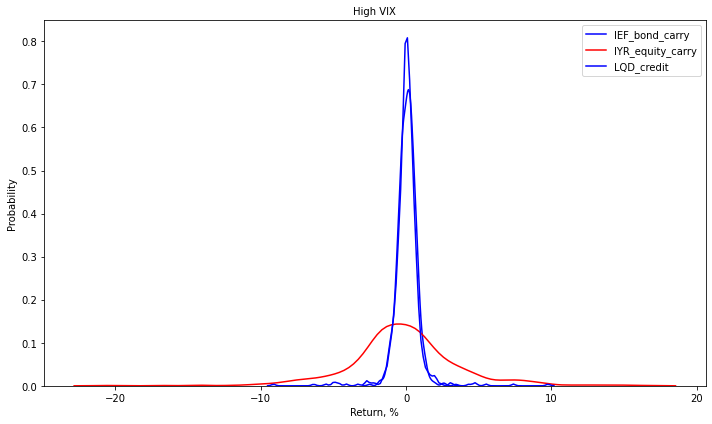

In [ ]:
len1= 1
len2 = 2
strategy_list_custom = ['IEF_bond_carry', 'IYR_equity_carry', 'LQD_credit']
import seaborn as sns
sns.distplot(df[item].loc[df['VIX'] > high_vix], hist=False, rug=False);

color_list_custom = ['b', 'r', 'blue']
# plot distribution of the portfolio conditional on view
%matplotlib inline
fig = plt.figure(figsize=(10,6))
#fig, axes =plt.subplots(2,2)
i = 0

for item in strategy_list_custom:
  #plt.subplot(len2, len1, i)
  sns.distplot(df[item].loc[df['VIX']>high_vix], hist=False, rug=False, color=color_list_custom[i], label=item);
 # _ = plt.hist(df[item].loc[df['VIX']<low_vix], density = True , bins = 20, facecolor ='g', alpha=0.5)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.xlabel('Return, %',fontsize = 10)
  plt.ylabel('Probability',fontsize = 10)
  plt.title('High VIX',fontsize = 10)
  plt.legend(strategy_list_custom)
  i+=1
fig.tight_layout()
fig.show()

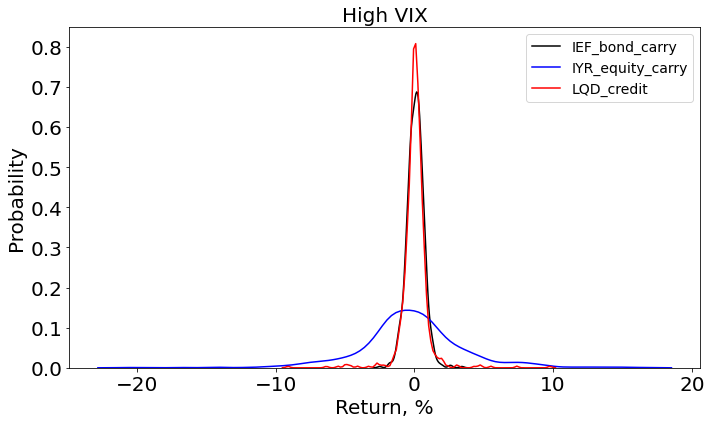

In [ ]:
fig = plt.figure(figsize=(10,6))
strategy_list_custom = ['IEF_bond_carry', 'IYR_equity_carry', 'LQD_credit']
color_list_custom = ['black', 'blue', 'r']
i=0
for item in strategy_list_custom:
  #plt.subplot(len2, len1, i)
  sns.distplot(df[item].loc[df['VIX']>high_vix], hist=False, rug=False, color=color_list_custom[i], label=item);
 # _ = plt.hist(df[item].loc[df['VIX']<low_vix], density = True , bins = 20, facecolor ='g', alpha=0.5)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.xlabel('Return, %',fontsize = 20)
  plt.ylabel('Probability',fontsize = 20)
  plt.title('High VIX',fontsize = 20)
  plt.legend(strategy_list_custom,fontsize = 14)
  i+=1
fig.tight_layout()
fig.show()